# Анализ клиентов регионального банка и выделение портрета клиентов, которые склонны уходить из Банка

## Материалы

**Презентация находится** [здесь](https://disk.yandex.ru/d/GEHkm6o457ZN-Q "Я ссылка"). 

**Дашборд находится** [здесь](https://public.tableau.com/app/profile/.20288363/viz/BankScroodgMacduck/Dashboard1?publish=yes)

## Описание проекта
Проанализируйте клиентов регионального банка и выделите портрет клиентов, которые склонны уходить из банка.
    
### Цель и задачи:
    - заказчик: отдел маркетинга
    - цель: предотвратить отток клиентов
    - задача: максимально эффективно выделить сегменты клиентов, чтобы они были однородными, высокоточными и покрывали максимум проблемных зон

### Описание данных
Банк
- USERID — идентификатор пользователя,
- score — баллы кредитного скоринга,
- city — город,
- gender — пол,
- age — возраст,
- equity — приблизительная оценка собственности клиента,
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- credit_card — есть ли кредитная карта,
- last_activity — был ли клиент активен последнее время,
- EST_SALARY — заработная плата клиента
- churn — уходит или нет.

## Загрузка данных и предобработка данных:

In [ ]:
!pip install phik

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from statsmodels.stats.proportion import proportions_ztest
from phik.report import plot_correlation_matrix

In [3]:
# чтение файла с данными и сохранение его в переменную
path = "https://drive.google.com/uc?export=download&id=1Q9_gSHSfe-AqwI3mLANe46jeS_CQMl8F"
df = pd.read_csv(path)

### Приведение названия колонок к одному виду

In [4]:
df.columns = df.columns.str.lower()
df

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,106217,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,113370,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814.0,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0
9996,139170,894.0,Ярославль,М,46,0,NaN,1,1,0,196898.29,0
9997,115639,903.0,Ярославль,М,24,0,NaN,2,1,1,108905.09,0
9998,148700,777.0,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0


### Выявление пропусков и заполнение их данными

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB


### Поиск и удаление дубликатов

In [6]:
df.duplicated().sum()

1

In [7]:
# попробуем убрать столбец с номером клиента
df.drop(columns=['userid'], axis=1).duplicated().sum()

1

In [8]:
# попробуем убрать столбец с городом, тк возможно клиент числится в разных городах
df.drop(columns=['city'], axis=1).duplicated().sum()

1

In [9]:
# убираем дубликат
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
# смотрим уникальные города, возможно там есть одни и теже названия с разной интерпритацией
sorted(df['city'].unique())

['Ростов', 'Рыбинск', 'Ярославль']

In [11]:
# смотрим пол, возможно там есть одни и теже названия с разной интерпритацией
sorted(df['gender'].unique())

['Ж', 'М']

In [12]:
df['userid'].duplicated().sum()

16

In [13]:
df[df['userid'].duplicated() == True].sort_values(by='userid')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
9631,185829,927.0,Ярославль,М,40,0,NaN,1,1,0,231254.86,0
9380,187459,894.0,Рыбинск,М,48,0,NaN,1,1,0,178012.28,0
2165,187635,692.0,Ярославль,Ж,44,0,NaN,1,1,1,160368.82,0
8015,198635,670.0,Ярославль,Ж,32,0,NaN,1,1,1,168699.33,0
9301,202983,942.0,Ростов,Ж,39,0,NaN,1,1,1,163804.73,0
8385,206759,915.0,Ярославль,М,22,0,NaN,1,1,0,71179.53,0
8449,210898,705.0,Ярославль,Ж,35,0,NaN,1,0,1,922080.25,0
8293,216848,930.0,Ярославль,М,34,0,NaN,1,1,1,199542.51,0
5470,218868,827.0,Ярославль,Ж,38,4,448959.07,2,1,1,67835.95,0
7248,219343,920.0,Ярославль,Ж,33,0,NaN,1,1,0,159248.67,0


In [14]:
df[df['userid'] == 185829]

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3668,185829,925.0,Ярославль,М,40,0,NaN,1,1,0,228305.64,0
9631,185829,927.0,Ярославль,М,40,0,NaN,1,1,0,231254.86,0


In [15]:
# убираем дубликат
df = df[df['userid'].duplicated() == False].reset_index(drop=True)
df

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,106217,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,113370,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9978,120553,814.0,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0
9979,139170,894.0,Ярославль,М,46,0,NaN,1,1,0,196898.29,0
9980,115639,903.0,Ярославль,М,24,0,NaN,2,1,1,108905.09,0
9981,148700,777.0,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0


### Поиск и удаление аномалий

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,9983.0,162455.081438,3.894598e+04,94561.0,128567.0000,162464.000,196192.00,2.291450e+05
score,9983.0,848.388761,6.574450e+01,642.0,801.0000,853.000,900.00,1.000000e+03
age,9983.0,42.846239,1.213171e+01,18.0,34.0000,40.000,51.00,8.600000e+01
equity,9983.0,2.630973,1.979875e+00,0.0,0.0000,3.000,4.00,9.000000e+00
balance,7702.0,827912.599891,1.980987e+06,0.0,295471.3975,524283.765,980849.31,1.191136e+08
products,9983.0,1.875388,7.999063e-01,0.0,1.0000,2.000,2.00,5.000000e+00
credit_card,9983.0,0.680056,4.664779e-01,0.0,0.0000,1.000,1.00,1.000000e+00
last_activity,9983.0,0.523390,4.994776e-01,0.0,0.0000,1.000,1.00,1.000000e+00
est_salary,9983.0,147766.864350,1.392587e+05,2546.3,75229.8900,119553.340,174495.66,1.395064e+06
churn,9983.0,0.182510,3.862839e-01,0.0,0.0000,0.000,0.00,1.000000e+00


In [17]:
# клиент банка не может иметь 0 продуктов, это ошибка, возможно он был клиентом и остался в базе, поэтому эти данные нужно удалить
df = df[df['products'] > 0].reset_index()
df

,index,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,0,106217,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,3,113370,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9977,9978,120553,814.0,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0
9978,9979,139170,894.0,Ярославль,М,46,0,NaN,1,1,0,196898.29,0
9979,9980,115639,903.0,Ярославль,М,24,0,NaN,2,1,1,108905.09,0
9980,9981,148700,777.0,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0


Т.к. баланс показывает очень огромный разброс - от 0 руб до 120 млн руб, то построим гистограмму распределения по балансу

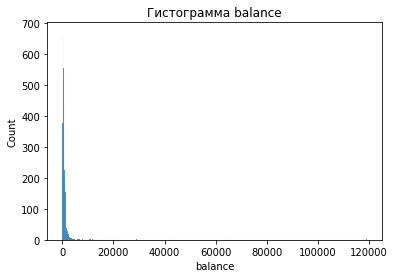

In [18]:
plt.figure(figsize=(6, 4))
sns.histplot(df, x=df['balance']/1000)
plt.title('Гистограмма balance')
plt.show()

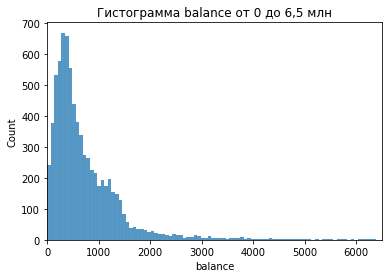

In [19]:
plt.figure(figsize=(6, 4))
sns.histplot(df, x=df['balance']/1000)
plt.xlim(0, 6500)
plt.title('Гистограмма balance от 0 до 6,5 млн')
plt.show()

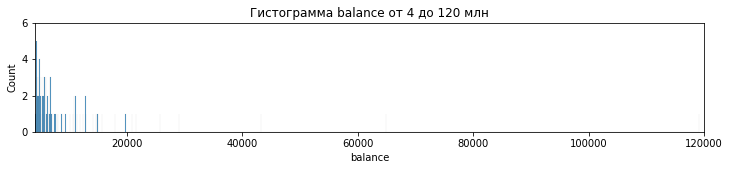

In [20]:
plt.figure(figsize=(12, 2))
sns.histplot(df, x=df['balance']/1000)
plt.xlim(4000, 120000)
plt.ylim(0, 6)
plt.title('Гистограмма balance от 4 до 120 млн')
plt.show()

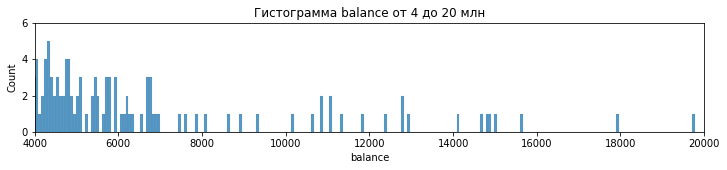

In [21]:
plt.figure(figsize=(12, 2))
sns.histplot(df, x=df['balance']/1000)
plt.xlim(4000, 20000)
plt.ylim(0, 6)
plt.title('Гистограмма balance от 4 до 20 млн')
plt.show()

Явные выбросы начиначаются после 6,5 млн руб по колонке баланс, но если оставить эту цифру - "поедет" средняя, а значит - и зависимости. Создадим два датафрейма с балансом до 4 млн и балансом до 6,5 млн, чтобы проследить разницу в данных.

In [22]:
df_4 = df.loc[(df['balance'] <= 4000000) | (df['balance'].isna() == True)].reset_index(drop=True)
df_4

,index,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,0,106217,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,3,113370,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9865,9978,120553,814.0,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0
9866,9979,139170,894.0,Ярославль,М,46,0,NaN,1,1,0,196898.29,0
9867,9980,115639,903.0,Ярославль,М,24,0,NaN,2,1,1,108905.09,0
9868,9981,148700,777.0,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0


In [23]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9870 entries, 0 to 9869
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          9870 non-null   int64  
 1   userid         9870 non-null   int64  
 2   score          9870 non-null   float64
 3   city           9870 non-null   object 
 4   gender         9870 non-null   object 
 5   age            9870 non-null   int64  
 6   equity         9870 non-null   int64  
 7   balance        7590 non-null   float64
 8   products       9870 non-null   int64  
 9   credit_card    9870 non-null   int64  
 10  last_activity  9870 non-null   int64  
 11  est_salary     9870 non-null   float64
 12  churn          9870 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1002.5+ KB


Потеряли незначительную часть данных - чуть более 1%

Мы отбрасываем их для анализа, потому что такие клиенты не являются "среднестатистическими". Эти клиенты уникальные, с уникальными потребностями и "заскоками". Возможно, их нужно анализировать отдельно, но массив данных слишком мал, чтобы делать точные выводы.

In [24]:
df_4.describe().T

,count,mean,std,min,25%,50%,75%,max
index,9870.0,4991.446403,2882.115543,0.0,2494.250,4991.500,7488.750,9982.00
userid,9870.0,162834.416413,38807.617871,94561.0,129488.250,163108.500,196309.000,229145.00
score,9870.0,847.256535,65.153519,642.0,801.000,851.000,899.000,999.00
age,9870.0,42.819959,12.140692,18.0,34.000,40.000,51.000,86.00
equity,9870.0,2.611246,1.979409,0.0,0.000,3.000,4.000,9.00
balance,7590.0,701202.129142,605899.455829,0.0,292735.440,514222.295,949253.450,3971985.11
products,9870.0,1.870314,0.797199,1.0,1.000,2.000,2.000,5.00
credit_card,9870.0,0.682168,0.465657,0.0,0.000,1.000,1.000,1.00
last_activity,9870.0,0.522695,0.499510,0.0,0.000,1.000,1.000,1.00
est_salary,9870.0,143150.557597,128032.451018,2546.3,74849.975,118653.955,172407.825,1333687.36


Максимальная зарплата почти не изменилась, остальные минимальные и максимальные данные остались прежними

In [25]:
df_6 = df.loc[(df['balance'] <= 6500000) | (df['balance'].isna() == True)].reset_index(drop=True)
df_6

,index,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,0,106217,850.0,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,1,146556,861.0,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,3,113370,866.0,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,4,157978,730.0,Ярославль,М,34,5,174.00,1,1,0,67353.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9933,9978,120553,814.0,Рыбинск,М,27,1,78144.65,1,0,1,18943.64,0
9934,9979,139170,894.0,Ярославль,М,46,0,NaN,1,1,0,196898.29,0
9935,9980,115639,903.0,Ярославль,М,24,0,NaN,2,1,1,108905.09,0
9936,9981,148700,777.0,Ярославль,Ж,68,3,865457.97,3,0,1,86874.90,0


In [26]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9938 entries, 0 to 9937
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          9938 non-null   int64  
 1   userid         9938 non-null   int64  
 2   score          9938 non-null   float64
 3   city           9938 non-null   object 
 4   gender         9938 non-null   object 
 5   age            9938 non-null   int64  
 6   equity         9938 non-null   int64  
 7   balance        7658 non-null   float64
 8   products       9938 non-null   int64  
 9   credit_card    9938 non-null   int64  
 10  last_activity  9938 non-null   int64  
 11  est_salary     9938 non-null   float64
 12  churn          9938 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 1009.5+ KB


Удалены 45 позиций, что составляет 0.5% от изначального датафрейма

In [27]:
df_6.describe().T

,count,mean,std,min,25%,50%,75%,max
index,9938.0,4990.788589,2882.208184,0.0,2494.2500,4991.500,7486.7500,9982.00
userid,9938.0,162623.357617,38891.844960,94561.0,129007.7500,162675.500,196233.5000,229145.00
score,9938.0,847.920105,65.473240,642.0,801.0000,852.000,899.0000,999.00
age,9938.0,42.832260,12.128523,18.0,34.0000,40.000,51.0000,86.00
equity,9938.0,2.623164,1.979764,0.0,0.0000,3.000,4.0000,9.00
balance,7658.0,739226.881622,727460.226250,0.0,294369.8175,518903.480,968183.2375,6349258.59
products,9938.0,1.874019,0.799282,1.0,1.0000,2.000,2.0000,5.00
credit_card,9938.0,0.681022,0.466104,0.0,0.0000,1.000,1.0000,1.00
last_activity,9938.0,0.522842,0.499503,0.0,0.0000,1.000,1.0000,1.00
est_salary,9938.0,145372.237167,132691.412424,2546.3,75052.2425,119257.825,173862.1400,1363549.52


При выборке по балансу до 6,5 млн максимальная зарплата практически равна максимальной в изначальном датафрейме, а остальные минимальные и максимальные данные так же остались прежними.

### Приведение данных к числовому формату и разбивка на категории, используя метод pandas.get_dummies()

In [28]:
df_4 = pd.get_dummies(df_4)
df_4.head()

,index,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,0,106217,850.0,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,3,113370,866.0,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,4,157978,730.0,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


In [29]:
df_6 = pd.get_dummies(df_6)
df_6.head()

,index,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,0,106217,850.0,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0
3,3,113370,866.0,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0
4,4,157978,730.0,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1


In [30]:
# Переименуем новые колонки
df_4 = df_4.rename(columns={'city_Ростов': 'Rostov', 'city_Рыбинск': 'Rybinsk', 'city_Ярославль': 'Yaroslavl', 
                            'gender_Ж': 'W', 'gender_М': 'M'})
df_4.head(3)

,index,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,W,M
0,0,106217,850.0,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0


In [31]:
# Переименуем новые колонки
df_6 = df_6.rename(columns={'city_Ростов': 'Rostov', 'city_Рыбинск': 'Rybinsk', 'city_Ярославль': 'Yaroslavl', 
                            'gender_Ж': 'W', 'gender_М': 'M'})
df_6.head(3)

,index,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,W,M
0,0,106217,850.0,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0


## Анализ данных
### Нахождение взаимосвязей:
#### - используя метод describe()
#### - используя функцию corr() и с помощью матрицы корреляций

In [32]:
df_4.describe().T

,count,mean,std,min,25%,50%,75%,max
index,9870.0,4991.446403,2882.115543,0.0,2494.250,4991.500,7488.750,9982.00
userid,9870.0,162834.416413,38807.617871,94561.0,129488.250,163108.500,196309.000,229145.00
score,9870.0,847.256535,65.153519,642.0,801.000,851.000,899.000,999.00
age,9870.0,42.819959,12.140692,18.0,34.000,40.000,51.000,86.00
equity,9870.0,2.611246,1.979409,0.0,0.000,3.000,4.000,9.00
balance,7590.0,701202.129142,605899.455829,0.0,292735.440,514222.295,949253.450,3971985.11
products,9870.0,1.870314,0.797199,1.0,1.000,2.000,2.000,5.00
credit_card,9870.0,0.682168,0.465657,0.0,0.000,1.000,1.000,1.00
last_activity,9870.0,0.522695,0.499510,0.0,0.000,1.000,1.000,1.00
est_salary,9870.0,143150.557597,128032.451018,2546.3,74849.975,118653.955,172407.825,1333687.36


In [33]:
df_6.describe().T

,count,mean,std,min,25%,50%,75%,max
index,9938.0,4990.788589,2882.208184,0.0,2494.2500,4991.500,7486.7500,9982.00
userid,9938.0,162623.357617,38891.844960,94561.0,129007.7500,162675.500,196233.5000,229145.00
score,9938.0,847.920105,65.473240,642.0,801.0000,852.000,899.0000,999.00
age,9938.0,42.832260,12.128523,18.0,34.0000,40.000,51.0000,86.00
equity,9938.0,2.623164,1.979764,0.0,0.0000,3.000,4.0000,9.00
balance,7658.0,739226.881622,727460.226250,0.0,294369.8175,518903.480,968183.2375,6349258.59
products,9938.0,1.874019,0.799282,1.0,1.0000,2.000,2.0000,5.00
credit_card,9938.0,0.681022,0.466104,0.0,0.0000,1.000,1.0000,1.00
last_activity,9938.0,0.522842,0.499503,0.0,0.0000,1.000,1.0000,1.00
est_salary,9938.0,145372.237167,132691.412424,2546.3,75052.2425,119257.825,173862.1400,1363549.52


Если внимательно посмотреть на средние и медианные величины всех показателей, можно сделать следующие выводы:
   - средние по обоим датафреймам отличаются незначительно
   - средняя оценка кредитного скоринга близка к медианной оценке (848) и ближе к максимальной оценке, чем к минимальной
   - средний возраст 42-43 года, стандартное отклонение - 12 лет - значительный разброс!
   - средняя оценка собственности: 2,6 - ближе к минимальному значению, против максимума - 9; даже 3 квартиль составляет 4
   - средний баланс: 701-739 тыс.руб., а стандартное отклонение - 606-727 тыс.руб. - значительный разброс по данному показателю среди клиентов; медиана значительно отличается от среднеего - и составляет чуть больше полмиллиона. И среднее и медиана находятся ближе к минимуму, значит основная масса клиентов содержит на балансе до 1 млн руб.
   - количество продуктов банка у каждого из клиентов в основном - 2 - это показывают среднее, медиана и 3 квартиль, максимальные 5 скорее всего у единиц
   - кредитная карта находится у 68% клиентов
   - активность в последнее время наблюдается у половины клиентов
   - по зарплате слишком большой разброс от 2 тыс. до 1,3 млн, поэтому правильнее смотреть на медиану по данной характеристике, которая составляет 119 тыс.руб.
   - из общего числа клиентов наблюдается отток в размере 18%, весомая цифра - почти 1/5!
   - среди 3 городов наибольшее число клиентов находятся в Ярославле (59%), наименьшее - в Ростове(14%), что объясняется численностью населения среди этих городов, если мы говором о Ростове Великом (все города находятся в Ярославской области)
   - соотношение мужчин и женщин практически 50% на 50%

In [34]:
((df_4.describe().T - df_6.describe().T) / df_6.describe().T).style.format("{:.2%}")\
    .background_gradient(axis=None,vmin=-0.05, vmax=0.05)

,count,mean,std,min,25%,50%,75%,max
index,-0.68%,0.01%,-0.00%,nan%,0.00%,0.00%,0.03%,0.00%
userid,-0.68%,0.13%,-0.22%,0.00%,0.37%,0.27%,0.04%,0.00%
score,-0.68%,-0.08%,-0.49%,0.00%,0.00%,-0.12%,0.00%,0.00%
age,-0.68%,-0.03%,0.10%,0.00%,0.00%,0.00%,0.00%,0.00%
equity,-0.68%,-0.45%,-0.02%,nan%,nan%,0.00%,0.00%,0.00%
balance,-0.89%,-5.14%,-16.71%,nan%,-0.56%,-0.90%,-1.96%,-37.44%
products,-0.68%,-0.20%,-0.26%,0.00%,0.00%,0.00%,0.00%,0.00%
credit_card,-0.68%,0.17%,-0.10%,nan%,nan%,0.00%,0.00%,0.00%
last_activity,-0.68%,-0.03%,0.00%,nan%,nan%,0.00%,0.00%,0.00%
est_salary,-0.68%,-1.53%,-3.51%,0.00%,-0.27%,-0.51%,-0.84%,-2.19%


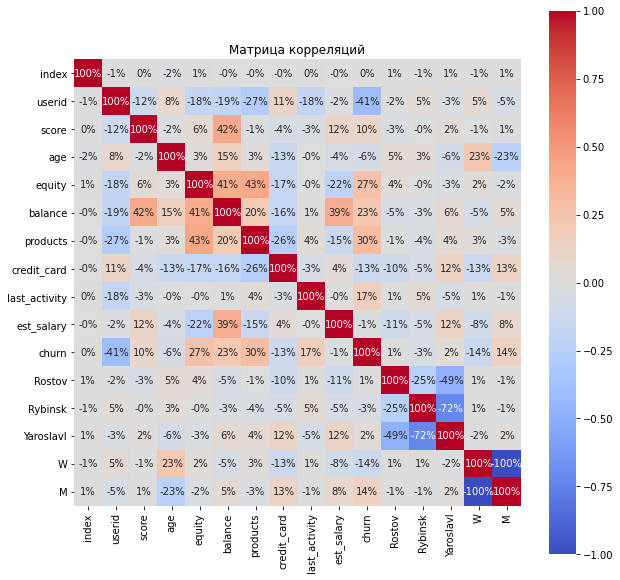

In [35]:
# Подсчитаем корреляцию признаков
corr_m_4 = df_4.corr()

# Построим матрицу корреляций
plt.figure(figsize= (10, 10))
ax = sns.heatmap(corr_m_4, square=True, annot=True, center=0, fmt='0.0%', cmap= 'coolwarm')   # нарисуем heatmap
#plt.xticks(rotation=60)
plt.title('Матрица корреляций')
plt.show()

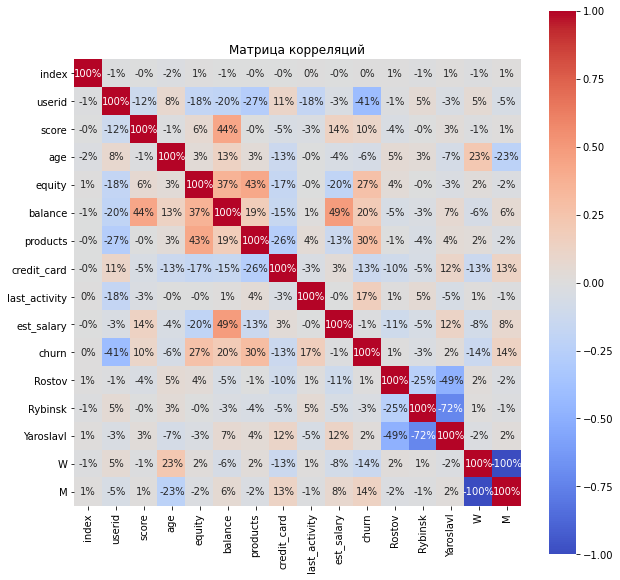

In [36]:
# Подсчитаем корреляцию признаков
corr_m_6 = df_6.corr()

# Построим матрицу корреляций
plt.figure(figsize= (10, 10))
ax = sns.heatmap(corr_m_6, square=True, annot=True, vmin=-1, vmax=1, center=0, fmt='0.0%', cmap= 'coolwarm')   # нарисуем heatmap
#plt.xticks(rotation=60)
plt.title('Матрица корреляций')
plt.show()

Зависимости у двух датафреймов схожи, незначительно отличается корреляция только у колонки "баланс". Но у датафрейма df_6 лучше прослеживается взамосвязь, чем у df_4

Матрица корреляций показывает линейные зависимоти. По матрице корреляций можно сделать следующие выводы:
   - Наибольшую зависимость показывает заработная плата - баланс, что вполне логично - чем выше зарплата, тем больше сумму клиент может держать на депозите/карте
   - Не будем принимать во внимание зависимость у городов, т.к. они друг друга взаимоисключают, такая же ситуация у пола.
   - Наибольшее количество зависимостей показывают индификатор пользователя (видимо, чем мешьше номер, тем клиент раньше стал пользоваться услугами банка), оценка собственности клиента, баланс, кол-во продуктов, заработная плата, уходит или нет
   - Наиболее весомые зависимости: индикатор - уход пользователя, скоринг - баланс, оценка собственности - баланс, оценка собственности - кол-во продуктов, заработная плата - баланс, кол-во продуктов - уход пользователя

interval columns not set, guessing: ['index', 'userid', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'Rostov', 'Rybinsk', 'Yaroslavl', 'W', 'M']


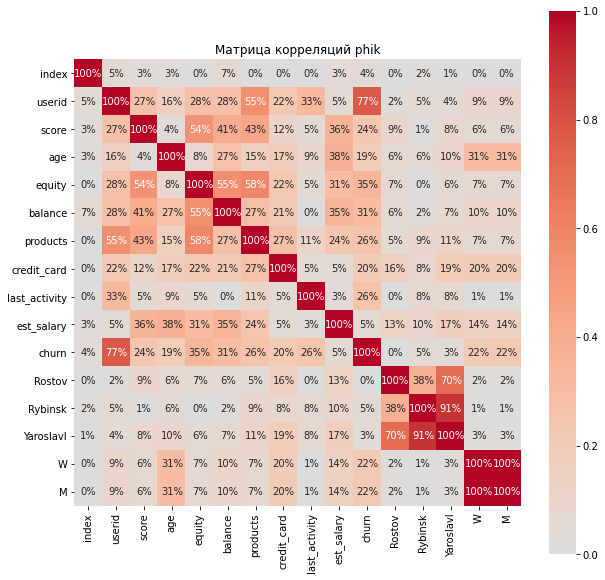

In [37]:
# Подсчитаем корреляцию признаков
phik_overview = df_4.phik_matrix()
phik_overview.round(2)

# Построим матрицу корреляций
plt.figure(figsize= (10, 10))
ax = sns.heatmap(phik_overview, square=True, annot=True, center=0, fmt='0.0%', cmap='coolwarm')   # нарисуем heatmap
#plt.xticks(rotation=60)
plt.title('Матрица корреляций phik')
plt.show()

interval columns not set, guessing: ['index', 'userid', 'score', 'age', 'equity', 'balance', 'products', 'credit_card', 'last_activity', 'est_salary', 'churn', 'Rostov', 'Rybinsk', 'Yaroslavl', 'W', 'M']


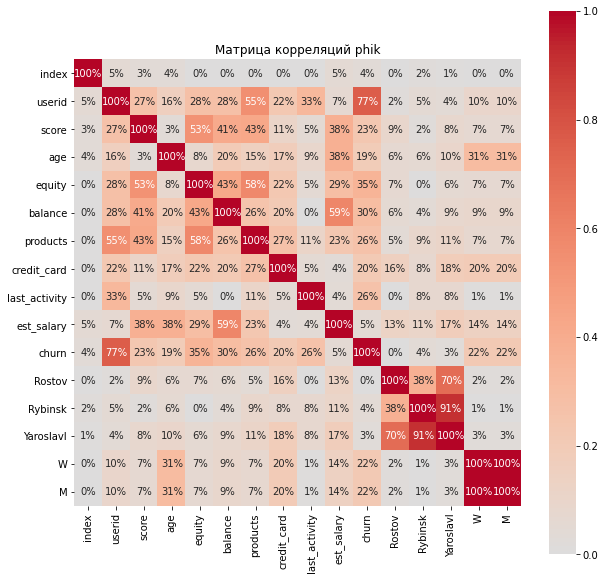

In [38]:
# Подсчитаем корреляцию признаков
phik_overview = df_6.phik_matrix()
phik_overview.round(2)

# Построим матрицу корреляций
plt.figure(figsize= (10, 10))
ax = sns.heatmap(phik_overview, square=True, annot=True, center=0, fmt='0.0%', cmap='coolwarm')   # нарисуем heatmap
#plt.xticks(rotation=60)
plt.title('Матрица корреляций phik')
plt.show()

Матрица корреляций показывает линейные зависимоти. По матрице корреляций phic можно сделать следующие выводы:
   - Не будем принимать во внимание зависимость у городов, т.к. они друг друга взаимоисключают, такая же ситуация у пола.
   - Наибольшую зависимость показывает индикатор - уход пользователя (видимо, предположение о том, что, чем мешьше номер, тем клиент раньше стал пользоваться услугами банка - верное)  
   - Наиболее весомы признаки: индификатор пользователя, баллы кредитного скоринга, оценка собственности клиента, баланс, кол-во продуктов, заработная плата, уходит или нет
   - К уже выявленным зависимостям можно добавить: индикатор - кол-во продуктов, индикатор - зарплата, скоринг - оценка собственности, скоринг - кол-во продуктов, скоринг - зарплата, возраст - зарплата, возраст - пол, оценка собственности - зарплата, оценка собственности - уход, баланс - уход, кол-во продуктов - наличие кредитной карты, активность в последнее время - индикатор.

**Оба вида корреляции показывают, что наибольшее влияние на уход/не уход клиента оказывают все факторы, относящиеся к его благосостоянию, а так же количество используемых банковских продуктов и индификатор клиента, т.е. на сколько давно он "пришел" в данный банк.**

#### - путем построения графика распределения признаков

Учитывая, что оба датафрема df_4 и df_6 показывают примерно одинаковые зависимости, а df_6 - более явные, то далее по проекту мы будет использовать только его, чтобы не загромождать код.

In [39]:
bool_columns=['credit_card', 'last_activity', 'churn', 'Rostov', 'Rybinsk', 'Yaroslavl', 'W', 'M']
numeric_columns=['userid', 'score', 'age', 'equity', 'balance', 'products', 'est_salary']

<Figure size 432x720 with 0 Axes>

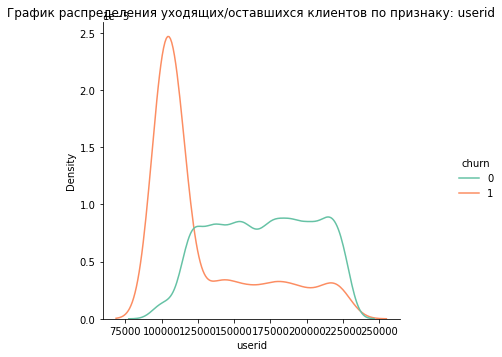

<Figure size 432x720 with 0 Axes>

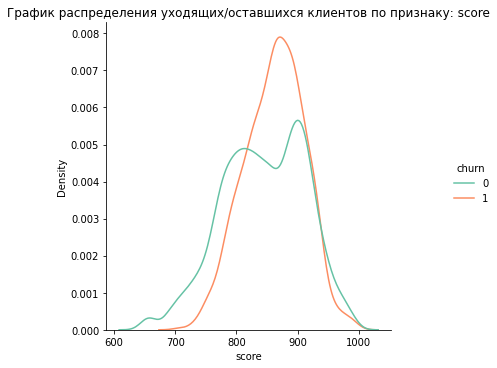

<Figure size 432x720 with 0 Axes>

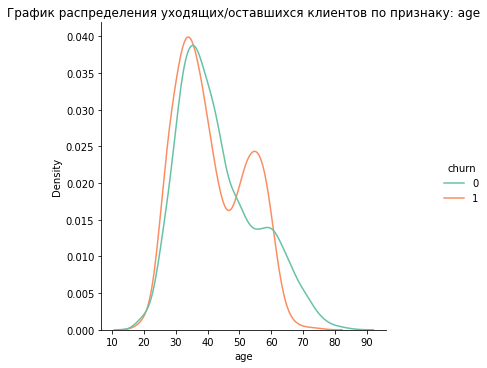

<Figure size 432x720 with 0 Axes>

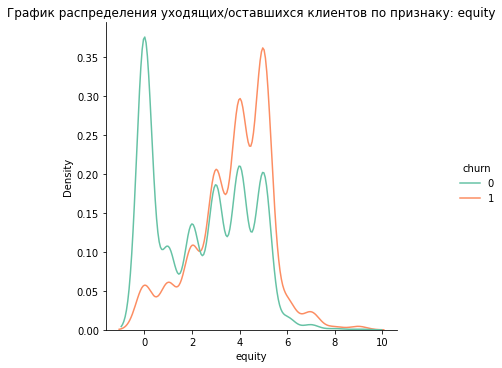

<Figure size 432x720 with 0 Axes>

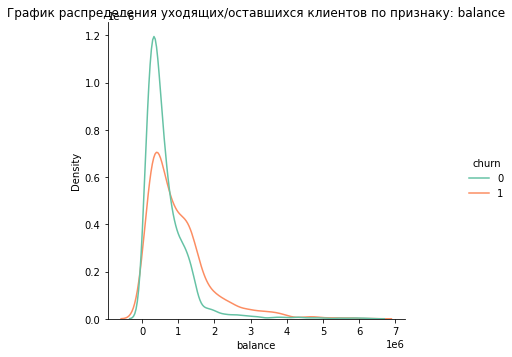

<Figure size 432x720 with 0 Axes>

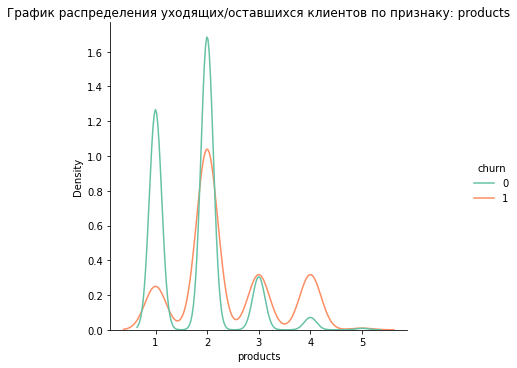

<Figure size 432x720 with 0 Axes>

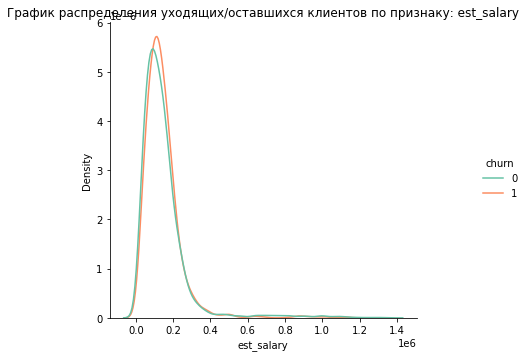

In [40]:
# Построим график распределения по основным признакам в разрезе кластеров
for col in numeric_columns:
    plt.figure(figsize=(6, 10))
    ax=sns.displot(data=df_6, x=col, hue='churn', palette='Set2', kind='kde', common_norm=False)
    plt.title('График распределения уходящих/оставшихся клиентов по признаку: {}'.format(col))    
    plt.show()

<Figure size 432x864 with 0 Axes>

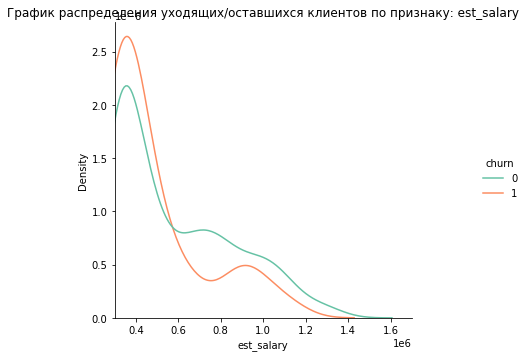

In [41]:
#Построим график зарплаты
fix = df_6.loc[df_6['est_salary'] > 300000]
plt.figure(figsize=(6, 12))
sns.displot(data=fix, x=fix['est_salary'], hue='churn', palette='Set2', kind='kde', common_norm=False)
plt.xlim(300000, 1700000)
plt.title('График распределения уходящих/оставшихся клиентов по признаку: est_salary')    
plt.show()

По графикам распределения можно сделать следующие выводы:
   - номерам индификатора от минимального до статысячного свойсвенный уход в большей степени, чем другим. Пик приходится на стотысячные номера, возможно эти клиенты были привелечены с помощью какой-нибудь рекламной акции
   - наибольший уход характерен для кредитного скоринга равному 870 баллов
   - если смотреть возраст, то наименее выгодное соотношение ушедших/оставшихся относится к возрастам 30-40, 50-60 лет
   - чем выше оценка состояния собственности клиента, тем более свойственен уход клиентов. Скорее всего, эти клиенты не пользуются кредитами, т.к. они достаточно обеспеченные, но и депозиты не держат, из-за того, что деньги куда-то вкладывают (собственный бизнес)
   - при балансе свыше 1,2 млн количество уходящих примерно равно количеству оставшихся клиентов
   - наибольший процент уходящих клиентов свойственен для пользователей, использующих 4 продукта (возможно эти клиенты были привлечены рекламной акцией или еще какими-либо действиями)
   - по зарплате - нет особых различий

#### - путем построения гистограмм

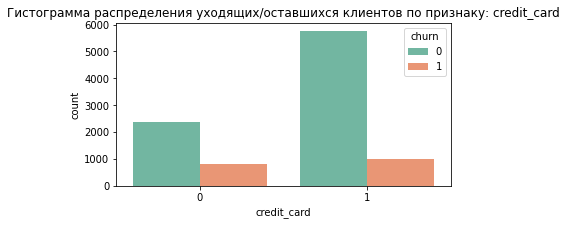

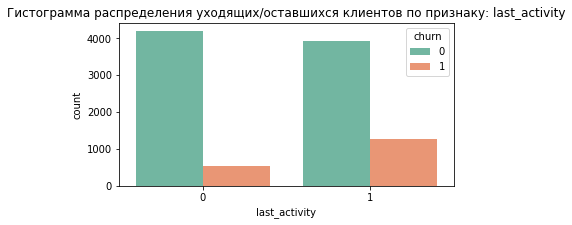

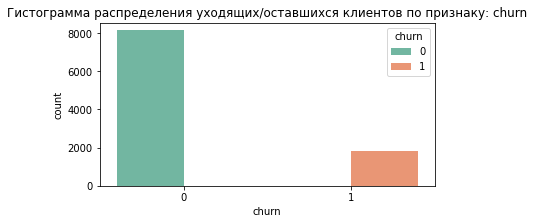

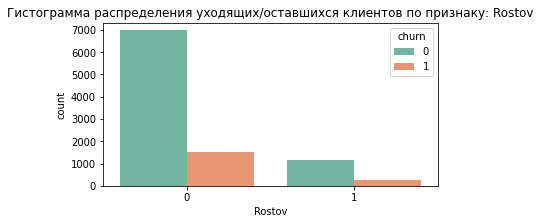

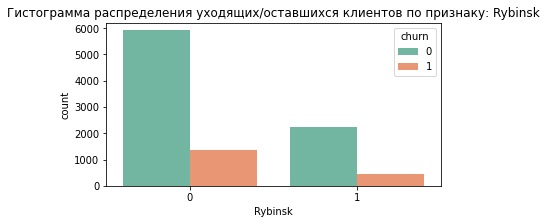

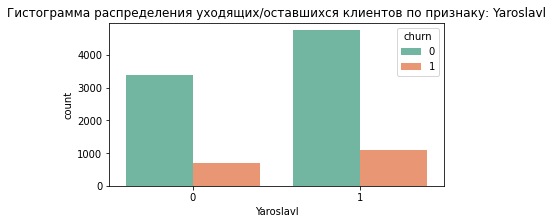

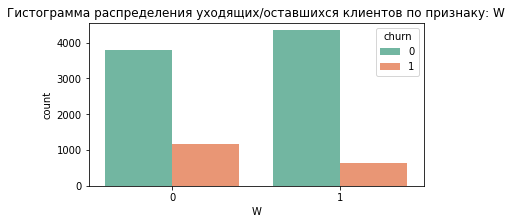

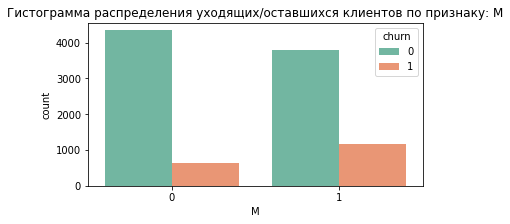

In [42]:
for col in bool_columns:
    plt.figure(figsize=(6, 3))
    ax=sns.countplot(data=df_6, x=col, hue='churn', palette='Set2')
    plt.title('Гистограмма распределения уходящих/оставшихся клиентов по признаку: {}'.format(col))
    plt.show()

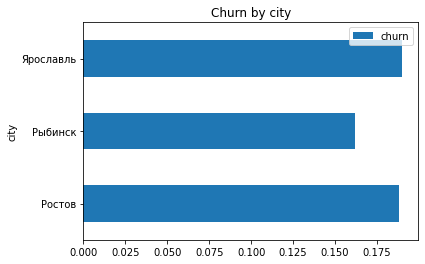

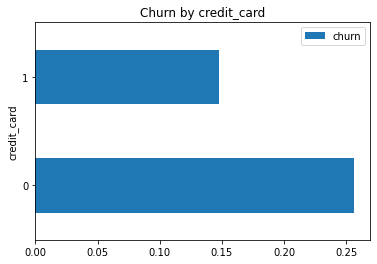

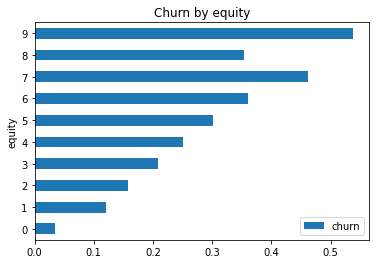

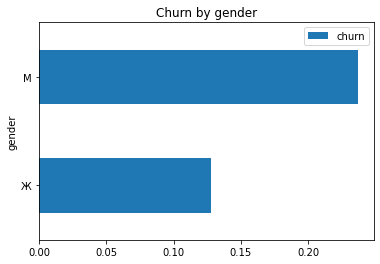

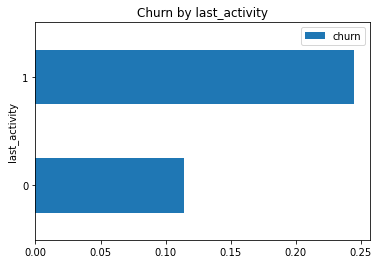

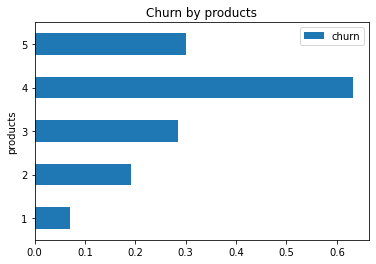

In [43]:
#Построим графики долей оттока в разрезе разных показателей:
for col in df.columns[df.nunique().lt(11)].difference(['churn']):
    df.groupby(col).agg({'churn':'mean'}).plot(kind="barh").set(title=f'Churn by {col}')

По данным гистогаммам можно сделать следующие выводы:
   - при отсутствии кредитной карты соотношение уходящих/оставшихся выше, чем при ее наличии у клиента
   - соотношение уходящих/оставшихся выше при положительной последней активности
   - соотношение уходящих/оставшихся в разрезе городов примерно одинаковое
   - среди мужчин уход более свойственен, чем среди женщин

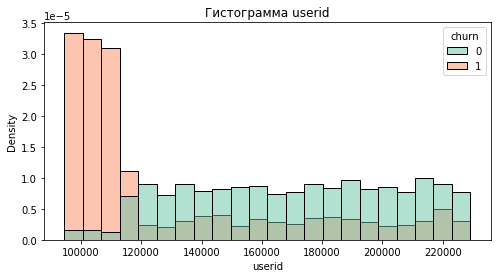

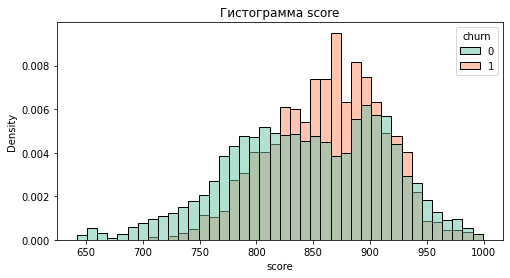

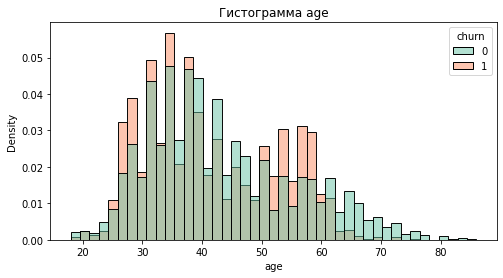

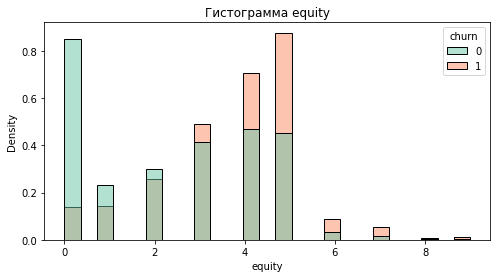

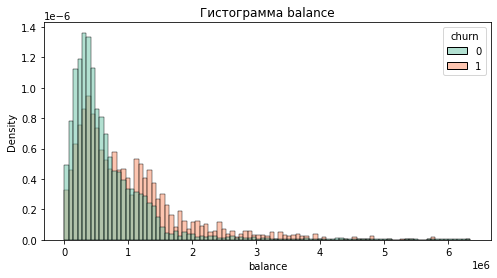

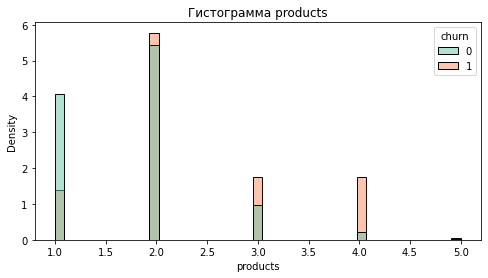

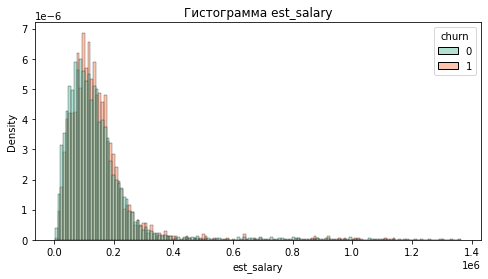

In [45]:
for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_6, x=col, hue='churn', palette='Set2', stat="density", common_norm=False)
    plt.title('Гистограмма {}'.format(col))
    plt.show()

Гистограммы по цифровым стоблцам подтверждают выше указанные выводы, но более точно интерпретируют зависимости:
   - номерам идентификатора от минимального до 119000 свойственен уход в большей степени, чем другим. Пик приходится на номера меньше 115000, возможно эти клиенты были привлечены с помощью какой-нибудь рекламной акции
   - наибольший уход характерен для кредитного скоринга, находящегося в пределах 830-930 баллов, а его пик = 870 баллов.
   - если смотреть возраст, то наименее выгодное соотношение ушедших/оставшихся относится к возрастам 24-35, 50-60 лет
   - чем выше оценка состояния собственности клиента, тем более свойственен уход клиентов. Скорее всего, эти клиенты не пользуются кредитами, т.к. они достаточно обеспеченные, но и депозиты не держат, из-за того, что деньги куда-то вкладывают (собственный бизнес)
   - при балансе свыше 0,7 млн количество уходящих превышает количество оставшихся клиентов
   - наибольший процент уходящих клиентов свойственен для пользователей, использующих 4 продукта (возможно эти клиенты были привлечены рекламной акцией или еще какими-либо действиями)
   - по некоторым уровням зарплаты есть небольшие превышения уходящих клиентов над оставшимся, но между этими областями ситуация обратная – оставшиеся пользователи превышают над уходящими

### Построение портретов клиентов. 

#### Построение графиков "ящик с усами"

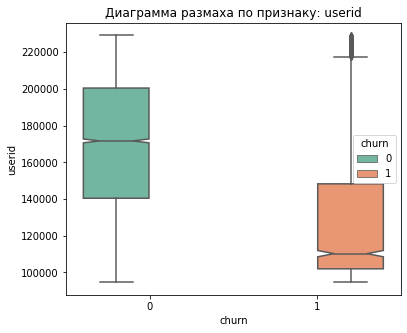

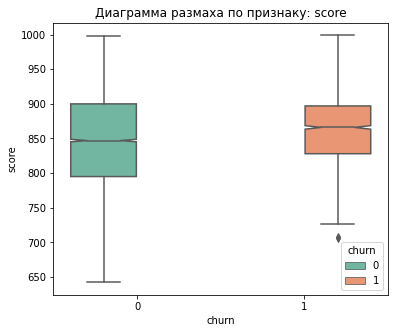

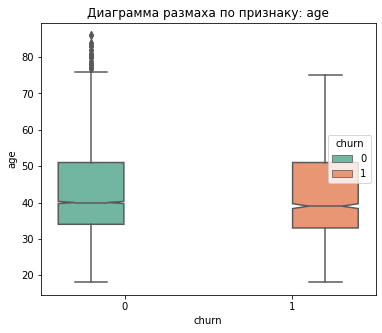

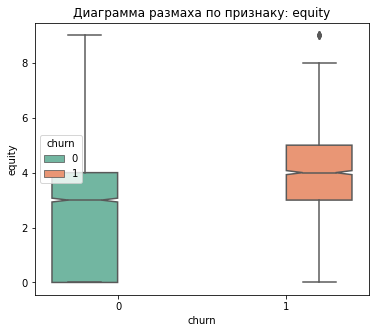

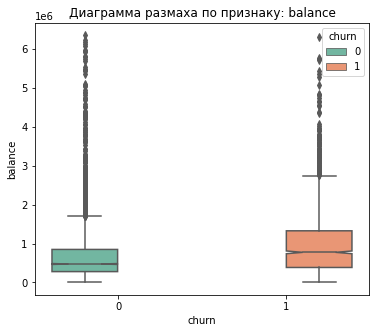

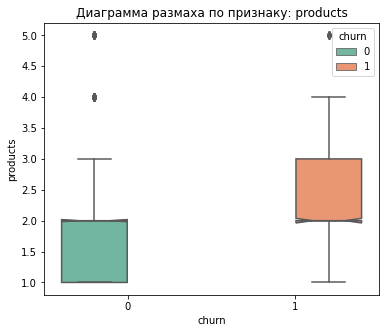

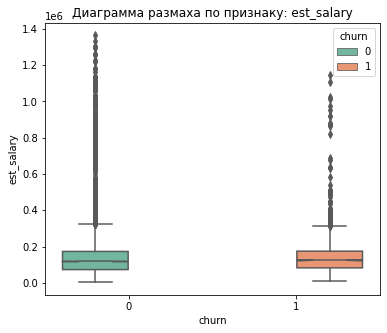

In [46]:
# Построим диаграммы размаха по разным показателям
for col in numeric_columns:   #bool_columns
    plt.figure(figsize=(6, 5))
    ax=sns.boxplot(data=df_6, x='churn', y=col, hue='churn', palette='Set2', notch = True)
    plt.title('Диаграмма размаха по признаку: {}'.format(col)) 
    #sns.despine(offset=5, trim=True)
    plt.show()

Диаграммы размаха подтверждают уже сделанные выводы по признакам в разрезе уходящих/оставшихся клиентов. Наиболее ярко выраженными признаками в разрезе уходящих/оставшихся клиентов являются:
   - идентификатор пользователя
   - оценка собственности клиента
   - количество продуктов

#### Проверка гипотезы

После того как рассмотрели все возможные графики и сделали по ним соответствующие выводы - рассмотрим два варианта гипотез, одну построим на основании "единогласного" вывода, а другую - где выводы значительно различаются. 

Среди бинарных показателей наибольшую корреляцию с уходом показали два признкака - последняя активность и пол. По моему мнению последняя активность в значительной доле предполагает закрытие кредита, депозита, кредитной карты, что уже само по себе доказывает уход клиента, а вот с гендерным признаком не до конца все понятно - поэтому выбран именно этот признак.

Другая гипотеза - проверяется именно для уточнения - есть все таки зависимость от дохода к оттоку или нет.

Проверим две гипотезы: о равенстве/отличии долей отточных клиентов в разрезе пола и о равенстве/отличии дохода между отточными и отставшимися клиентами.

Так как нам нужно сравнить две выборки, то необходимо использовать следующий метод стат теста: метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind (array1, array2, equal_var).

Требования к данному методу следующие: 
   - Генеральные совокупности не должны зависеть друг от друга.
   - Выборочные средние должны быть нормально распределены.
   - Дисперсии рассматриваемых генеральных совокупностей должны быть равны.
   
   Первые два условия соблюдены, а вот по третьему условию есть одно "но" - выборки по размеру отличаются (отточных клиентов мешьше в 4 раза), поэтому будем использовать параметр equal_var = False («правило большого пальца»: если выборки разного размера и/или можно предположить, что дисперсии у генеральных совокупностей разные).
   
   *Наши обе ситуации подходят под требования выше указанного теста, поэтому его применение целесообразно.*

Проверим первую гипотезу: **Равенство/отличие долей отточных клиентов в разрезе пола**

 - А(0) - нулевая гипотеза: "Доли отточных клиентов в разрезе пола одинаковые"
 - А(1) - альтернативная гипотеза: "Доли отточных клиентов в разрезе пола различаются"
   
Критический уровень значимости используем 5%. 

In [47]:
exist = df_6[df_6['churn'] == False].reset_index(drop=True) # оставшиеся клиенты

outflow = df_6[df_6['churn'] == True].reset_index(drop=True) # ушедшие клиенты

In [49]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    exist['M'], 
    outflow['M'],
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 6.743053101289897e-46
Отвергаем нулевую гипотезу


In [50]:
# Второй способ проверки гипотезы
alpha = 0.05
trials_1 = df.gender.eq("М").sum() # пол мужчина/попытки
trials_2 = df.gender.eq("Ж").sum() # пол женщина/попытки
success_1 = df.gender.eq("М").rmul(df.churn.eq(1)).sum() #ушёл в отток/успех
success_2 = df.gender.eq("Ж").rmul(df.churn.eq(1)).sum() #ушла в отток/успех
counts = np.array([success_1, success_2])
nobs = np.array([trials_1, trials_2])
display(pd.DataFrame(np.c_[nobs,counts].T,columns=['М','Ж'],index=['Попытки','Успехи']))
stat, pval = proportions_ztest(counts, nobs)
print('p-значение: {0:0.2e}'.format(pval))
if pval < alpha:
    print("Отвергаем нулевую гипотезу: между долями значительная разница")
else: 
    print("Не получилось отвергнуть нулевую гипотезу,нет оснований считать доли разными")

,М,Ж
Попытки,4998,4984
Успехи,1184,637


p-значение: 3.28e-45
Отвергаем нулевую гипотезу: между долями значительная разница


Получили ничтожно малый p-value, можно сказать, что он равен 0, а это значит, что у нас нет оснований для потверждения нулевой гипотезы, следовательно принимаем альтернативную гипотезу - Доли отточных клиентов в разрезе пола отличаются, впрочем, как и показывали графики.

А теперь проверим вторую гипотезу: **Равенство/отличие дохода между отточными и отставшимися клиентами**. Вообще, большинство графиков не показывали особых отличий в доходах клиентов, которые ушли и которые остались. Проверим это стат тестом.

 - А(0) - нулевая гипотеза: "Средний доход среди отточных клиентов и теми которые остались не различается"
 - А(1) - альтернативная гипотеза: "Средний доход среди отточных клиентов и теми которые остались"
   
Критический уровень значимости используем 5%. 

In [51]:
alpha = 0.05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

exist # оставшиеся клиенты

outflow # ушедшие клиенты


results = st.ttest_ind(
    exist['est_salary'], 
    outflow['est_salary'],
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.3265834785863242
Не получилось отвергнуть нулевую гипотезу


Значение p-value более 0,32, это значит, что значения по показателю "заработная плата" совпадают в выборках по отточным и оставшимся клиентам на 32%, следовательно отвергнуть нулевую гипотезу не получится, т.е. вывод по графикам "нет особых отличий в доходах клиентов, которые ушли и которые остались" оказался верным.

Соберем выводы в одном месте.

Если внимательно посмотреть на средние и медианные величины всех показателей, можно сделать следующие выводы:
   - средние по обоим датафреймам отличаются незначительно
   - средняя оценка кредитного скоринга близка к медианной оценке (847 и 852) и ближе к максимальной оценке, чем к минимальной
   - средний возраст 42-43 года, стандартное отклонение - 12 лет - значительный разброс!
   - средняя оценка собственности: 2,6 - ближе к минимальному значению, против максимума - 9; даже 3 квартиль составляет 4
   - средний баланс: 701-749 тыс.руб., а стандартное отклонение - 606-727 тыс.руб. - значительный разброс по данному показателю среди клиентов; медиана значительно отличается от среднеего - и составляет чуть больше полмиллиона. И среднее и медиана находятся ближе к минимуму, значит основная масса клиентов содержит на балансе до 1 млн руб.
   - количество продуктов банка у каждого из клиентов в основном - 2 - это показывают среднее, медиана и 3 квартиль, максимальные 5 скорее всего у единиц
   - кредитная карта находится у 68% клиентов
   - активность в последнее время наблюдается у половины клиентов
   - по зарплате слишком большой разброс от 2 тыс. до 1,3 млн, поэтому правильнее смотреть на медиану по данной характеристике, которая составляет 119 тыс.руб.
   - из общего числа клиентов наблюдается отток в размере 18%, весомая цифра - почти 1/5!
   - среди 3 городов наибольшее число клиентов находятся в Ярославле (58%), наименьшее - в Ростове(14%), что объясняется численностью населения среди этих городов, если мы говором о Ростове Великом (все города находятся в Ярославской области)
   - соотношение мужчин и женщин практически 50% на 50%

Матрица корреляций показывает линейные зависимоти. По матрице корреляций можно сделать следующие выводы:
   - Наибольшую зависимость показывает заработная плата - баланс, что вполне логично - чем выше зарплата, тем больше сумму клиент может держать на депозите/карте
   - Не будем принимать во внимание зависимость у городов, т.к. они друг друга взаимоисключают, такая же ситуация у пола.
   - Наибольшее количество зависимостей показывают индификатор пользователя (видимо, чем мешьше номер, тем клиент раньше стал пользоваться услугами банка), оценка собственности клиента, баланс, кол-во продуктов, заработная плата, уходит или нет
   - Наиболее весомые зависимости: индикатор - уход пользователя, скоринг - баланс, оценка собственности - баланс, оценка собственности - кол-во продуктов, заработная плата - баланс, кол-во продуктов - уход пользователя

Матрица корреляций показывает линейные зависимоти. По матрице корреляций phic можно сделать следующие выводы:

   - Не будем принимать во внимание зависимость у городов, т.к. они друг друга взаимоисключают, такая же ситуация у пола.
   - Наибольшую зависимость показывает индикатор - уход пользователя (видимо, предположение о том, что, чем мешьше номер, тем клиент раньше стал пользоваться услугами банка - верное)
   - Наиболее весомы признаки: индификатор пользователя, баллы кредитного скоринга, оценка собственности клиента, баланс, кол-во продуктов, заработная плата, уходит или нет
   - К уже выявленным зависимостям можно добавить: индикатор - кол-во продуктов, индикатор - зарплата, скоринг - оценка собственности, скоринг - кол-во продуктов, скоринг - зарплата, возраст - зарплата, возраст - пол, оценка собственности - зарплата, оценка собственности - уход, баланс - уход, кол-во продуктов - наличие кредитной карты, активность в последнее время - индикатор.

**Оба вида корреляции показывают, что наибольшее влияние на уход/не уход клиента оказывают все факторы, относящиеся к его благосостоянию, а так же количество используемых банковских продуктов и индификатор клиента, т.е. на сколько давно он "пришел" в данный банк.**

По графикам распределения можно сделать следующие выводы:
   - номерам индификатора от минимального до статысячного свойсвенный уход в большей степени, чем другим. Пик приходится на стотысячные номера, возможно эти клиенты были привелечены с помощью какой-нибудь рекламной акции
   - наибольший уход характерен для кредитного скоринга равному 870 баллов
   - если смотреть возраст, то наименее выгодное соотношение ушедших/оставшихся относится к возрасту 50-60 лет
   - чем выше оценка состояния собственности клиента, тем более свойственен уход клиентов. Скорее всего, эти клиенты не пользуются кредитами, т.к. они достаточно обеспеченные, но и депозиты не держат, из-за того, что деньги куда-то вкладывают (собственный бизнес)
   - при балансе свыше 1,7 млн количество уходящих примерно равно количеству оставшихся клиентов
   - наибольший процент уходящих клиентов свойственен для пользователей, использующих 4 продукта (возможно эти клиенты были привлечены рекламной акцией или еще какими-либо действиями)
   - по зарплате сложно сказать - соотношение 1 к 4 примерно везде

По данным гистогаммам можно сделать следующие выводы:
   - при отсутствии кредитной карты соотношение уходящих/оставшихся выше, чем при ее наличии у клиента
   - соотношение уходящих/оставшихся выше при положительной последней активности
   - соотношение уходящих/оставшихся в разрезе городов примерно одинаковое
   - среди мужчин уход более свойственен, чем среди женщин

Диаграммы размаха подтверждают уже сделанные выводы по признакам в разрезе уходящих/оставшихся клиентов. Наиболее ярко выраженными признаками в разрезе уходящих/оставшихся клиентов являются:
   - идентификатор пользователя
   - оценка собственности клиента
   - количество продуктов

Гистограммы по цифровым стоблцам подтверждают выше указанные выводы, но более точно интерпретируют зависимости:
   - номерам идентификатора от минимального до 119000 свойственен уход в большей степени, чем другим. Пик приходится на номера меньше 115000, возможно эти клиенты были привлечены с помощью какой-нибудь рекламной акции
   - наибольший уход характерен для кредитного скоринга, находящегося в пределах 830-930 баллов, а его пик = 870 баллов.
   - если смотреть возраст, то наименее выгодное соотношение ушедших/оставшихся относится к возрастам 24-35, 50-60 лет
   - чем выше оценка состояния собственности клиента, тем более свойственен уход клиентов. Скорее всего, эти клиенты не пользуются кредитами, т.к. они достаточно обеспеченные, но и депозиты не держат, из-за того, что деньги куда-то вкладывают (собственный бизнес)
   - при балансе свыше 0,7 млн количество уходящих превышает количество оставшихся клиентов
   - наибольший процент уходящих клиентов свойственен для пользователей, использующих 4 продукта (возможно эти клиенты были привлечены рекламной акцией или еще какими-либо действиями)
   - по некоторым уровням зарплаты есть небольшие превышения уходящих клиентов над оставшимся, но между этими областями ситуация обратная – оставшиеся пользователи превышают над уходящими

Получили ничтожно малый p-value, можно сказать, что он равен 0, а это значит, что у нас нет оснований для потверждения нулевой гипотезы, следовательно принимаем альтернативную гипотезу - Доли отточных клиентов в разрезе пола отличаются, впрочем, как и показывали графики.

Значение p-value более 0,32, это значит, что значения по показателю "заработная плата" совпадают в выборках по отточным и оставшимся клиентам на 32%, следовательно отвергнуть нулевую гипотезу не получится, т.е. вывод по графикам "нет особых отличий в доходах клиентов, которые ушли и которые остались" оказался верным.

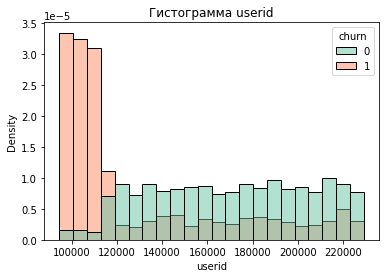

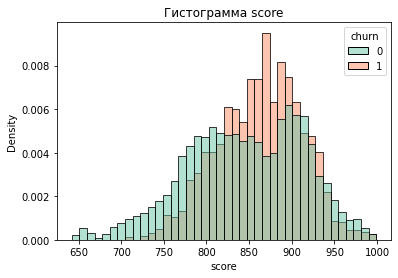

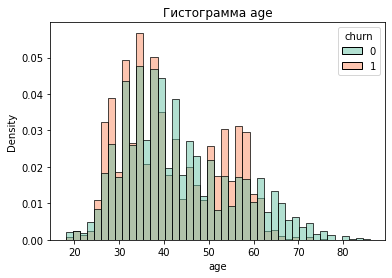

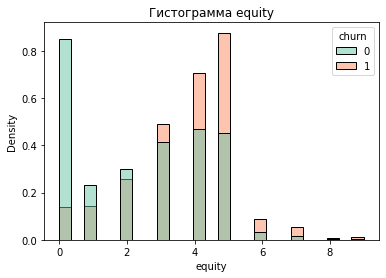

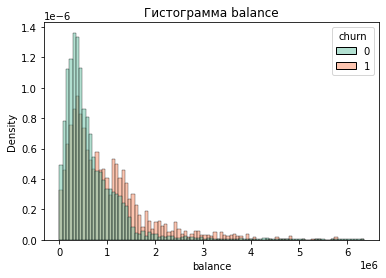

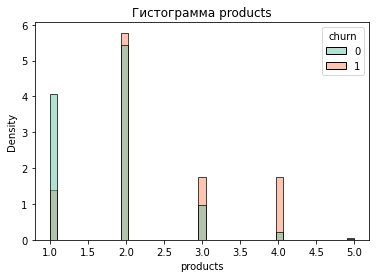

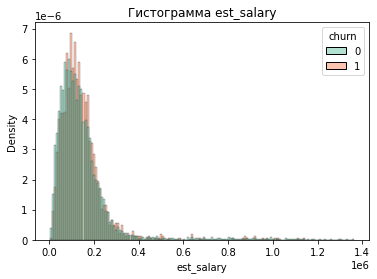

In [52]:
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_6, x=col, hue='churn', palette='Set2', stat="density", common_norm=False)
    plt.title('Гистограмма {}'.format(col))
    plt.show()

**По всем выше указанным выводам можно составить следующие портреты клиентов - уходящих и оставшихся. Начнем с уходящих.**

**Прекратившим сотрудничество с банком "Скрудж Макдак" наиболее свойственны следующие признаки:**
   - **идентификатор пользователя до №119000**
   - **оценка собственности клиента - 3 и более**
   - **клиенты, которые пользуются 2 и более продуктами**
   - **баланс более 700 тыс.руб.**
   - **скоринг 830-930**
   - **возраст 24-37, 50-60**
   - **отсутствие кредитной карты**
   - **положительная последняя активность**
   - **мужской пол**
   
**Клиентам, продолжающим сотрудничество с банком свойственны следующие признаки:**
   - **идентификатор пользователя после №119000**
   - **оценка собственности клиента - от 0 до 2 включительно**
   - **клиенты, которые используют менее 2 продуктов**
   - **баланс менее 700 тыс.руб.**
   - **скоринг до 830 и более 930**
   - **возраст: 18-24, 38-50 и более 60**
   - **наличие кредитной карты**
   - **отрицательная последняя активность**
   - **женский пол**

## Сегментация

### Формируем группы

На основе выделенных выше признаков по ушедшим и оставшимся клиентам сформируем группы по следующим признакам:
   - идентификатор пользователя
   - возраст
   - количество продуктов
   - баланс

In [53]:
df_6.head(3)

,index,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,W,M
0,0,106217,850.0,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0
1,1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0
2,2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0


In [54]:
# Создадим функцию для разбивки индификаторов на две группы
def id_category(id):
    if  id <= 115000:
        return 'id_1'
    return 'id_2'

In [55]:
df_6['id_cat'] = df_6['userid'].apply(id_category)
df_6.head()

,index,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,W,M,id_cat
0,0,106217,850.0,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,id_1
1,1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,id_2
2,2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0,id_2
3,3,113370,866.0,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,id_1
4,4,157978,730.0,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,id_2


Данную категорию предлагаю использовать совместо с другими категориями

In [56]:
id = df_6.groupby(['id_cat', 'churn'])[['churn']].count()
tmp = df_6.groupby(['id_cat'])[['churn']].count()
id['percentage'] = round((id['churn'] / tmp['churn']) * 100, 2)
id.columns=['count', 'percentage']
id.reset_index(inplace=True)
id = id.rename(columns={'id_cat': 'category'})
id

,category,churn,count,percentage
0,id_1,0,264,18.44
1,id_1,1,1168,81.56
2,id_2,0,7871,92.53
3,id_2,1,635,7.47


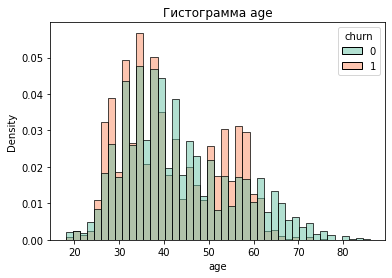

In [57]:
plt.figure(figsize=(6, 4))
sns.histplot(df_6, x='age', hue='churn', palette='Set2', stat="density", common_norm=False)
plt.title('Гистограмма age'.format(col))
plt.show()

In [58]:
# Создадим функцию для разбивки возраста на категории
def age_category(age):
    if  age <= 24:
        return 'age_1'
    if 24 < age <= 30:
        return 'age_2'
    if 30 < age <= 35:
        return 'age_3'
    if 35 < age <= 42:
        return 'age_4'
    if 42 < age <= 50:
        return 'age_5'
    if 50 < age <= 60:
        return 'age_6'
    return 'age_7'

In [59]:
df_6['age_cat'] = df_6['age'].apply(age_category)
df_6.head()

,index,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,W,M,id_cat,age_cat
0,0,106217,850.0,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,id_1,age_2
1,1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,id_2,age_4
2,2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0,id_2,age_2
3,3,113370,866.0,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,id_1,age_6
4,4,157978,730.0,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,id_2,age_3


In [60]:
age = df_6.groupby(['age_cat', 'churn'])[['churn']].count()
tmp = df_6.groupby(['age_cat'])[['churn']].count()
age['percentage'] = round((age['churn'] / tmp['churn']) * 100, 2)
age.columns=['count', 'percentage']
age.reset_index(inplace=True)
age = age.rename(columns={'age_cat': 'category'})
age

,category,churn,count,percentage
0,age_1,0,144,87.80
1,age_1,1,20,12.20
2,age_2,0,904,75.90
3,age_2,1,287,24.10
4,age_3,0,1511,79.95
5,age_3,1,379,20.05
6,age_4,0,2047,83.72
7,age_4,1,398,16.28
8,age_5,0,1414,85.85
9,age_5,1,233,14.15


Количество продуктов само по себе является категорией, поэтому нет смысла создавать дополнительный столбец, а можно только наглядно посмотреть какой % оттока у каждой "категории": 

In [61]:
prod = df_6.groupby(['products', 'churn'])[['churn']].count()
tmp = df_6.groupby(['products'])[['churn']].count()
prod['percentage'] = round((prod['churn'] / tmp['churn']) * 100, 2)
prod.columns=['count', 'percentage']
prod.reset_index(inplace=True)
prod = prod.rename(columns={'products': 'category'})
prod

,category,churn,count,percentage
0,1,0,3087,92.98
1,1,1,233,7.02
2,2,0,4110,80.92
3,2,1,969,19.08
4,3,0,744,71.54
5,3,1,296,28.46
6,4,0,173,36.89
7,4,1,296,63.11
8,5,0,21,70.00
9,5,1,9,30.00


In [62]:
# Создадим функцию для разбивки баланса на категории
def balance_category(balance):
    if  balance <= 300000:
        return 'balance_1'
    if 300000 < balance <= 700000:
        return 'balance_2'
    if 700000 < balance <= 1000000:
        return 'balance_3'
    if 1000000 < balance <= 2000000:
        return 'balance_4'
    if 2000000 < balance <= 4000000:
        return 'balance_5'
    if 4000000 < balance <= 6500000:
        return 'balance_6'
    return 'balance_7'

In [63]:
df_6['balance_cat'] = df_6['balance'].apply(balance_category)
df_6.head()

,index,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,W,M,id_cat,age_cat,balance_cat
0,0,106217,850.0,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,id_1,age_2,balance_1
1,1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,id_2,age_4,balance_3
2,2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0,id_2,age_2,balance_7
3,3,113370,866.0,51,5,1524746.26,2,0,1,174423.53,1,0,0,1,1,0,id_1,age_6,balance_4
4,4,157978,730.0,34,5,174.00,1,1,0,67353.16,1,0,0,1,0,1,id_2,age_3,balance_1


In [64]:
balance = df_6.groupby(['balance_cat', 'churn'])[['churn']].count()
tmp = df_6.groupby(['balance_cat'])[['churn']].count()
balance['percentage'] = round((balance['churn'] / tmp['churn']) * 100, 2)
balance.columns=['count', 'percentage']
balance.reset_index(inplace=True)
balance = balance.rename(columns={'balance_cat': 'category'})
balance

,category,churn,count,percentage
0,balance_1,0,1646,83.85
1,balance_1,1,317,16.15
2,balance_2,0,2332,82.14
3,balance_2,1,507,17.86
4,balance_3,0,761,74.32
5,balance_3,1,263,25.68
6,balance_4,0,936,64.64
7,balance_4,1,512,35.36
8,balance_5,0,144,45.57
9,balance_5,1,172,54.43


### Проверяем размер сегментов, выделяем наиболее весомые по отношению к оттоку

In [65]:
df_6.head(3)

,index,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,W,M,id_cat,age_cat,balance_cat
0,0,106217,850.0,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,id_1,age_2,balance_1
1,1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,id_2,age_4,balance_3
2,2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0,id_2,age_2,balance_7


Построим графики сегментов, которые у нас получились

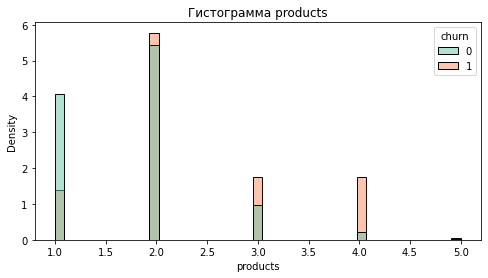

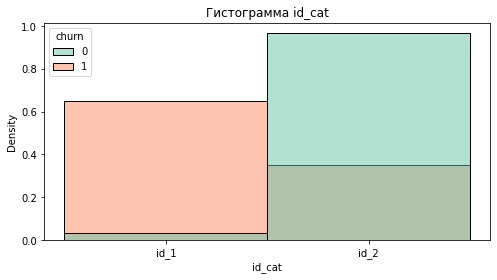

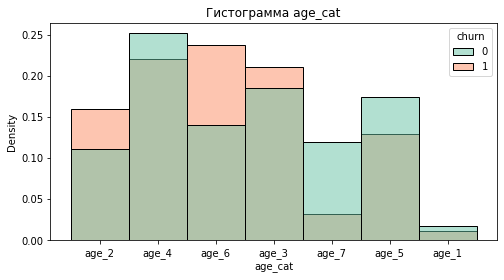

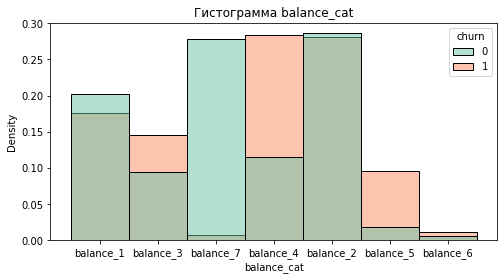

In [66]:
category = ['products', 'id_cat', 'age_cat', 'balance_cat',]
for col in category:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_6, x=col, hue='churn', palette='Set2', stat="density", common_norm=False)
    plt.title('Гистограмма {}'.format(col))
    plt.show()

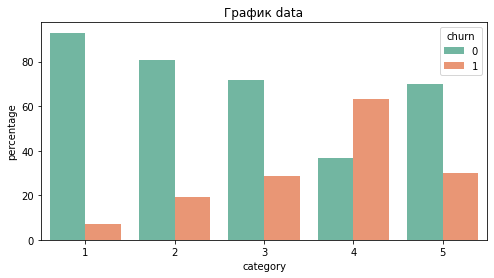

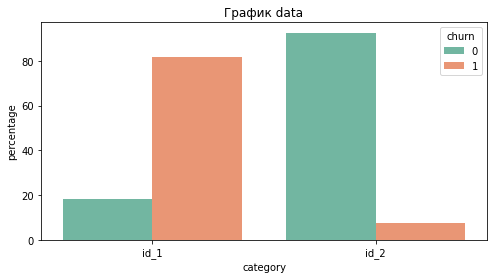

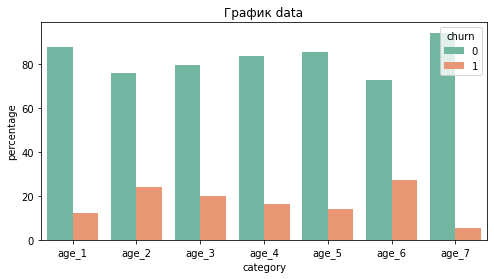

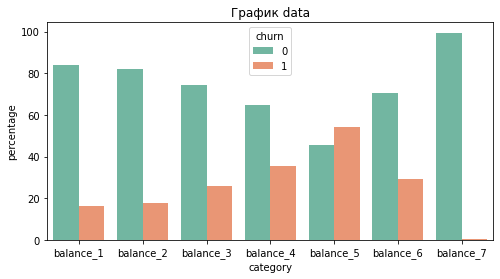

In [67]:
category_df = [prod, id, age, balance]
#category = ['products', 'id_cat', 'age_cat', 'balance_cat']
for data in category_df:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=data, y=data['percentage'], x=data['category'], hue=data['churn'], palette='Set2')
    plt.title('График {}'.format('data'))
    plt.show()

Разбить на категории удалось, среди категорий явно заметны "лидеры" по оттоку клиентов:
   - в продуктовых сегментах оказалось наиболее уязвимыми клиенты с числом продуктов - 4, что составляет чуть более 60% среди уходящих от общего количества в группе, а в численном эквиваленте - 296 человек
   - сегмент по идентификатору пользователя id_1 содержит около 82% отточных клиентов, эта группа насчитывает 1168 человек 
   - в сегментах по возрасту наиболее уязвимыми к уходу оказались клиенты в группах 6 и 2, их доли составляют 1/4 от общего количества в группе, а в численном эквиваленте - 393 и 287 соответственно
   - в группах по балансу 5 группа оказалась в наименее выгодном положении - 55% отточных клиентов или 172 человека
   
   Чуть выше было высказано предложение по совместному использованию двух сегментов одновременно - это сегмент по идентификатору и любой другой. Пересечение двух признаков нам даст меньшее количество клиентов в группах - это необходимо для старта "антиооточной" компании, что была меньшая нагрузка для маркетологов. 
   
   Посмотрим, что получится, если объединить каждый из оставшихся сегментов с сегментом по идентификатору.

In [68]:
df_6_tmp = df_6[df_6['id_cat'] == 'id_1']
prod_1 = df_6_tmp.groupby(['products', 'churn'])[['churn']].count()
tmp = df_6_tmp.groupby(['products'])[['churn']].count()
prod_1['percentage'] = round((prod_1['churn'] / tmp['churn']) * 100, 2)
prod_1.columns=['count', 'percentage']
prod_1.reset_index(inplace=True)
prod_1 = prod_1.rename(columns={'products': 'category'})
prod_1

,category,churn,count,percentage
0,1,0,14,13.08
1,1,1,93,86.92
2,2,0,44,6.57
3,2,1,626,93.43
4,3,0,12,7.69
5,3,1,144,92.31
6,4,0,173,36.89
7,4,1,296,63.11
8,5,0,21,70.00
9,5,1,9,30.00


In [69]:
df_6.head(3)

,index,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,Rostov,Rybinsk,Yaroslavl,W,M,id_cat,age_cat,balance_cat
0,0,106217,850.0,25,1,59214.82,2,0,1,75719.14,1,0,1,0,1,0,id_1,age_2,balance_1
1,1,146556,861.0,37,5,850594.33,3,1,0,86621.77,0,0,1,0,1,0,id_2,age_4,balance_3
2,2,120722,892.0,30,0,NaN,1,1,1,107683.34,0,0,1,0,1,0,id_2,age_2,balance_7


In [70]:
age_1 = df_6_tmp.groupby(['age_cat', 'churn'])[['churn']].count()
tmp = df_6_tmp.groupby(['age_cat'])[['churn']].count()
age_1['percentage'] = round((age_1['churn'] / tmp['churn']) * 100, 2)
age_1.columns=['count', 'percentage']
age_1.reset_index(inplace=True)
age_1 = age_1.rename(columns={'age_cat': 'category'})
age_1

,category,churn,count,percentage
0,age_1,0,6,37.50
1,age_1,1,10,62.50
2,age_2,0,51,17.89
3,age_2,1,234,82.11
4,age_3,0,56,15.77
5,age_3,1,299,84.23
6,age_4,0,68,19.94
7,age_4,1,273,80.06
8,age_5,0,45,27.44
9,age_5,1,119,72.56


In [71]:
balance_1 = df_6_tmp.groupby(['balance_cat', 'churn'])[['churn']].count()
tmp = df_6_tmp.groupby(['balance_cat'])[['churn']].count()
balance_1['percentage'] = round((balance_1['churn'] / tmp['churn']) * 100, 2)
balance_1.columns=['count', 'percentage']
balance_1.reset_index(inplace=True)
balance_1 = balance_1.rename(columns={'balance_cat': 'category'})
balance_1

,category,churn,count,percentage
0,balance_1,0,62,35.23
1,balance_1,1,114,64.77
2,balance_2,0,89,23.42
3,balance_2,1,291,76.58
4,balance_3,0,24,11.48
5,balance_3,1,185,88.52
6,balance_4,0,41,9.47
7,balance_4,1,392,90.53
8,balance_5,0,18,9.78
9,balance_5,1,166,90.22


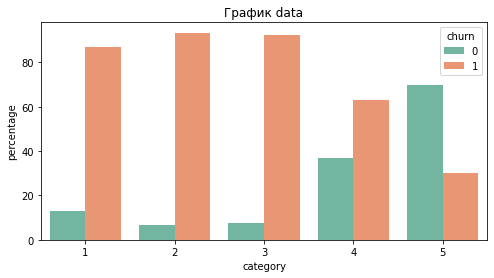

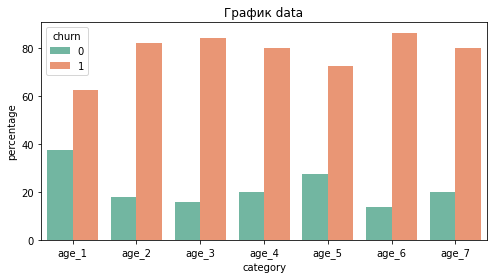

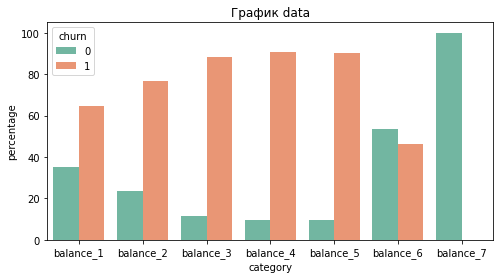

In [72]:
category_df = [prod_1, age_1, balance_1]

for data in category_df:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=data, y=data['percentage'], x=data['category'], hue=data['churn'], palette='Set2')
    plt.title('График {}'.format('data'))
    plt.show()

Как резко поменялись графики! 

Запротоколируем изменения:
   - в продуктовых сегментах группа с числом продуктов - 4 не изменилась, а вот другие - наборот. Получается, что если маркетологи будут работать со старыми клиентам, у которых номер идентификатора меньше 115000, то с 2 и 3 продуктовыми группами необходимо поработать в первую очередь, т.к. отток в этих группах составляет более 90% 
   - в сегментах по возрасту, с которыми необходимо поработать можно так же оставить группы 6 и 2, только численность клиентов снизилась - 206 и 234 соответственно
   - в группах по балансу к 5 группе можно добавить и группу №4, в которых отток составляет более 90% или 166 и 392 человека соответственно.

## Выводы

**Как показал анализ, банк в последнее время потерял почти 1/5 своей клиентуры. Что бы клиенты и дальше не "убегали" необходимо провести ряд действий по их удержанию. Этим будет заниматься отдел маркетинга, а ему в помощь был проделан данный анализ для понимания портрета клиента - уходящего и оставшегося, который заключается в следующем:**
   - **Прекратившим сотрудничество с банком "Скрудж Макдак" наиболее свойственны следующие признаки:**
      - **идентификатор пользователя до №115000**
      - **оценка собственности клиента - 3 и более**
      - **клиенты, которые пользуются 2 и более продуктами**
      - **баланс более 700 тыс.руб.**
      - **скоринг 830-930**
      - **возраст 25-37, 50-60**
      - **отсутствие кредитной карты**
      - **положительная последняя активность**
      - **мужской пол**
   - **Клиентам, продолжающим сотрудничество с банком свойственны следующие признаки:**
      - **идентификатор пользователя после №115000**
      - **оценка собственности клиента - от 0 до 2 включительно**
      - **клиенты, которые используют менее 2 продуктов**
      - **баланс менее 700 тыс.руб.**
      - **скоринг до 830 и более 930**
      - **возраст: 18-24, 38-50 и более 60**
      - **наличие кредитной карты**
      - **отрицательная последняя активность**
      - **женский пол**

**, а так же была проведена сегментация пользователей, при помощи которой были выявлены группы, наиболее подверженые оттоку клиентов. Для предотвращения оттока клиентов необходимо в первую очередь обратить внимание на следующие группы пользователей:**
   - **в первую очередь, необходимо отобрать старых клиентов, у которых номер идентификатора меньше 115000, и среди отобранных нужно обратить внимание на следующие группы:**  
      - **в продуктовых сегментах - c группами №2 и №3  необходимо поработать в первую очередь, т.к. отток в них составляет более 90%, а после этих действий можно поработать с группой №4**
      - **в сегментах по возрасту, с которыми необходимо поработать являются группами №6 и №2**
      - **в сегменте по балансу, в первую очередь стоит обратить внимание на группы №5 и №4, в которых отток составляет более 90% или 166 и 392 человека соответственно.**
   - **после того, как будет проработан первый поток, необходимо уже прорабатывать не только старых, но и новых клиентов, которые попали в следующе группы:**
      - **как уже было указано выше, в продуктовых сегментах так же наиболее уязвимыми являются клиенты с числом продуктов - 4, что составляет чуть более 60% среди уходящих от общего количества в группе, с этой группой необходима кропотливая работа**
      - **необходимо продолжить работу в сегментах по возрасту среди групп 6 и 2, т.к. доли их оттока составляют 1/4 от общего количества в группе**
      - **в группах по балансу продолжать работать сначала с 5 группой, а после с - 4.**
      
Для предотвращения оттока клиентов необходимо провести ряд следующиех действий по их удержанию с учетом проведенного анализа и сегментации:
Выяснить почему клиенты уходят. Это можно сделать следующими способами:  
   - Спросить у самих клиентов, по какой причине они больше не пользуются услугами. Чтобы получить реальные данные, разговаривать с клиентом должен внешний, не связанный с клиентом сотрудник. Это может быть другой менеджер, который представится «консультантом по качеству» или «директором по сервису». 
   - Провести опрос среди сотрудников компании о причинах ухода клиентов. Чтобы получить достоверную информацию, провести анонимный опрос сотрудников, которые непосредственно работают с клиентами. 
   - Провести мозговой штурм с сотрудниками. Накидать десяток причин, по которым наблюдается уход клиентов. Возможно, родятся инсайты по работе и сдерживанию оттока.

Все выявленные причины условно объединяются в три группы:
   - Действия конкурентов (лучшие условия по кредиту/вкладу/кредитной карте)
   - Действия компании (плохое обслуживание или клиентский сервис)
   - Действия клиента (отсутствие в потребности в услугах банка)

На первые две причины банк может повлиять, а на третью - нет. Остается - предлагать особые условия для уже существующих клиентов, а так же можно внедрить новый "особый" продукт, кроме этого, улучшать обслуживание (возможно замена определенных сотрудников, которые негативно повлияли на решение клиента).